/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2078 - val_loss: 0.0412 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0326 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0219 - val_loss: 0.0209 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0167 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0161 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 10/100
23/23

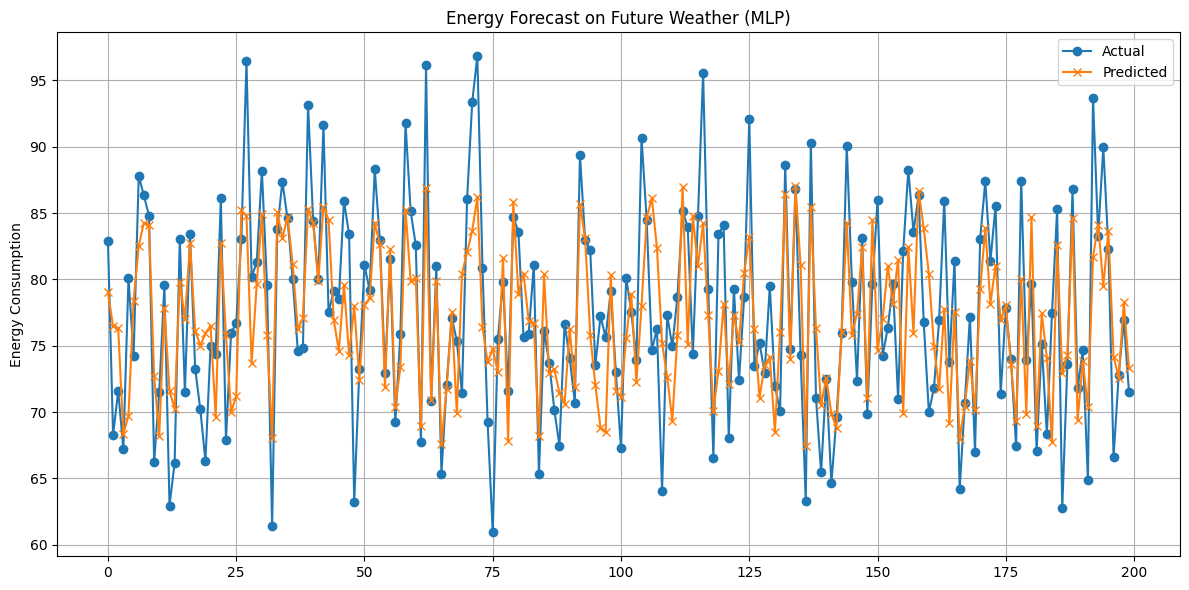

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === Load and Engineer Data ===
df = pd.read_csv("Energy_consumption.csv", parse_dates=["Timestamp"], index_col="Timestamp")
df = df[['Temperature', 'Humidity', 'EnergyConsumption']].dropna()

# === Features ===

features = ['Temperature', 'Humidity']
target = 'EnergyConsumption'

# === Chronological Split ===
train_end = int(0.8 * len(df)) # Split 80% for training and 20% for testing
train_df = df.iloc[:train_end]
test_df = df.iloc[train_end:]

# === Normalize ===
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(train_df[features])
y_train_scaled = scaler_y.fit_transform(train_df[[target]])

X_test_scaled = scaler_X.transform(test_df[features])
y_test_scaled = scaler_y.transform(test_df[[target]])

# === Manual Chronological Validation Split ===
val_split = int(0.9 * len(X_train_scaled))
X_subtrain = X_train_scaled[:val_split]
y_subtrain = y_train_scaled[:val_split]
X_val = X_train_scaled[val_split:]
y_val = y_train_scaled[val_split:]

# === Build and Train MLP ===
# The model is a simple feedforward neural network with two hidden layers
# The first layer has 64 neurons and uses ReLU activation
# The second layer has 32 neurons and also uses ReLU activation
# The output layer has 1 neuron and no activation function
# The model is compiled with the Adam optimizer and mean squared error loss function

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_subtrain.shape[1],)),
    #Dropout(0.2),  # Randomly disables 20% of neurons during each training step (Prevents overfitting)
    #Dense(64, activation='relu'),
        # Not needed for this simple model
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True) # Prevents overfitting
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5) # Prevents overfitting

model.fit(
    X_subtrain, y_subtrain,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    shuffle=False,  # Time series data should not be shuffled
    verbose=1
)

# === Predict and Evaluate on Unseen Future Test Set ===
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"\n✅ Final Evaluation on Chronologically Held-Out Test Set")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

# ===  Plot Results ===
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title("Energy Forecast on Future Weather (MLP)")
plt.ylabel("Energy Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1731 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0236 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0172 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0144 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0128 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 10/100
23/23 ━━━━━━━━━━━

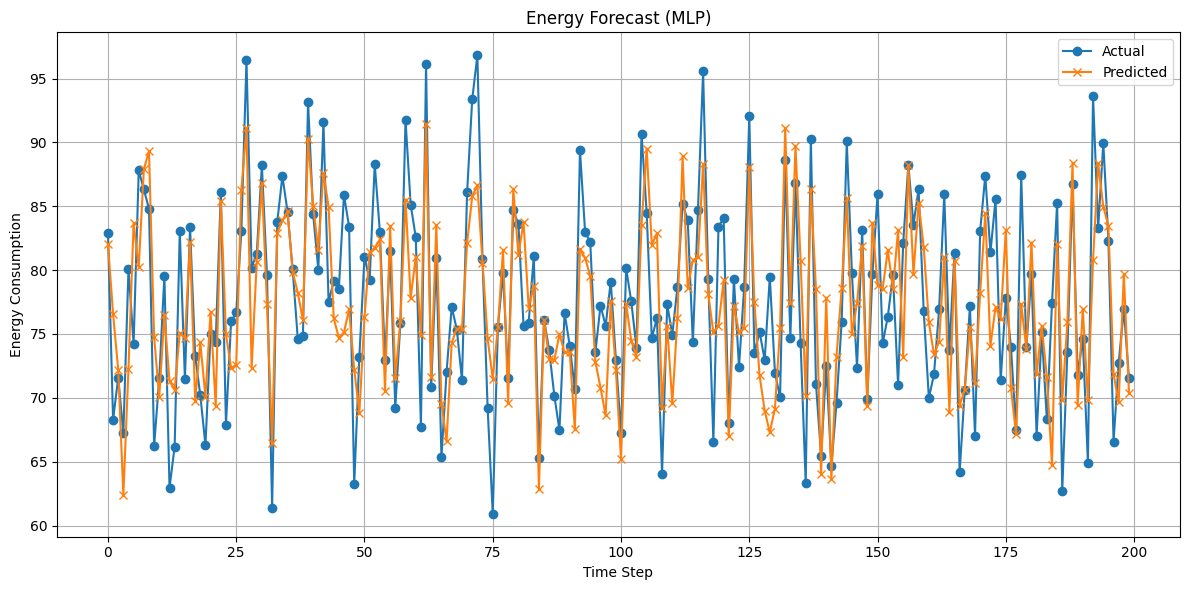

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === Load and Engineer Data ===
df = pd.read_csv("Energy_consumption.csv", parse_dates=["Timestamp"], index_col="Timestamp")
df = df[['Temperature', 'Humidity', 'Occupancy', 'SquareFootage', 'RenewableEnergy', 'HVACUsage', 'EnergyConsumption']].dropna()
df['HVACUsage'] = df['HVACUsage'].str.strip().str.lower().map({'off': 0, 'on': 1})
# === Features ===

features = ['Temperature', 'Humidity', 'Occupancy', 'SquareFootage', 'RenewableEnergy', 'HVACUsage']
target = 'EnergyConsumption'

# === Chronological Split ===
train_end = int(0.8 * len(df)) # Split 80% for training and 20% for testing
train_df = df.iloc[:train_end]
test_df = df.iloc[train_end:]

# === Normalize ===
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(train_df[features])
y_train_scaled = scaler_y.fit_transform(train_df[[target]])

X_test_scaled = scaler_X.transform(test_df[features])
y_test_scaled = scaler_y.transform(test_df[[target]])

# === Manual Chronological Validation Split ===
val_split = int(0.9 * len(X_train_scaled))
X_subtrain = X_train_scaled[:val_split]
y_subtrain = y_train_scaled[:val_split]
X_val = X_train_scaled[val_split:]
y_val = y_train_scaled[val_split:]

# === Build and Train MLP ===
# The model is a simple feedforward neural network with two hidden layers
# The first layer has 64 neurons and uses ReLU activation
# The second layer has 32 neurons and also uses ReLU activation
# The output layer has 1 neuron and no activation function
# The model is compiled with the Adam optimizer and mean squared error loss function

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_subtrain.shape[1],)),
    #Dropout(0.2),  # Randomly disables 20% of neurons during each training step (Prevents overfitting)
    Dense(32, activation='relu'),
        # Not needed for this simple model
    #Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True) # Prevents overfitting
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5) # Prevents overfitting

model.fit(
    X_subtrain, y_subtrain,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    shuffle=False,  # Time series data should not be shuffled
    verbose=1
)

# === Predict and Evaluate on Unseen Future Test Set ===
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"\n✅ Final Evaluation on Chronologically Held-Out Test Set")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

# ===  Plot Results ===
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title("Energy Forecast (MLP)")
plt.xlabel("Time Step")
plt.ylabel("Energy Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()